In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plot_series(time,series,format='-',start = 0 , end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [ ]:
def trend(time,slope=0):
  return slope*time

In [ ]:
def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time*2*np.pi),1/np.exp(3*season_time))

In [ ]:
def seasonality(time,period,amplitude=1,phase=0):
  season_time = ((time+phase) % period) / period
  return amplitude*seasonal_pattern(season_time) 

In [ ]:
def noise(time,noise_level=1,seed=None):
  rnd =np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

In [ ]:
time = np.arange(10*365 + 1 , dtype='float32')
baseline = 10
amplitude = 40 
slope = 0.05
noise_level = 3

In [ ]:
series = baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)
series += noise(time,noise_level,seed=51)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

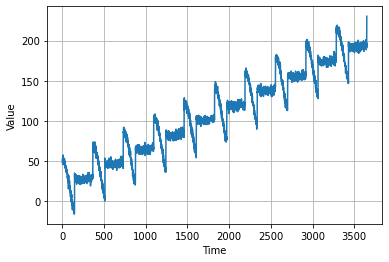

In [ ]:

plot_series(time,series)

In [ ]:
#the above is the plot of the synthetic data

In [ ]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(batch_size))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1],window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [ ]:
print(dataset)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>


In [ ]:
#haha Cause Tensorflow works as a graph it isn't executed yet

In [ ]:
#Now Creating a Model 
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(100,activation='relu',input_shape=[window_size]),
                             tf.keras.layers.Dense(10,activation='relu'),
                             tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9))

In [ ]:
history = model.fit(dataset,epochs=100,verbose=0)

In [ ]:
forecast = []
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

In [ ]:
forecast = forecast[split_time-window_size:]
result = np.array(forecast)[:,0,0]
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,result)
plt.show()